# Creating Train Test Split and Augmenting dataset to generate images to prevent overfitting while training


## Download Data from Kaggle using Kaggle API commands

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d truthisneverlinear/bach-breast-cancer-histology-images
!unzip /content/BACH.zip

100% 12.5G/12.5G [03:05<00:00, 82.4MB/s]
100% 12.5G/12.5G [03:05<00:00, 72.4MB/s]


In [ ]:
!mkdir /content/BACHtrain
!mkdir /content/BACHtest

In [ ]:
!rm -rf /content/BACHtrain
!rm -rf /content/BACHtest

In [2]:
!mkdir /content/BACHAugment

In [3]:
!mkdir /content/BACHAugment/Benign
!mkdir /content/BACHAugment/InSitu
!mkdir /content/BACHAugment/Invasive
!mkdir /content/BACHAugment/Normal

## Spliting the data into Train and Test of the ratio 75:25

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Path to your dataset directory
dataset_dir = '/content/ICIAR2018_BACH_Challenge/ICIAR2018_BACH_Challenge/Photos'

# List all class directories in the dataset directory
class_dirs = os.listdir(dataset_dir)

# Create train and test directories
train_dir = '/content/BACHtrain'
test_dir = '/content/BACHtest'
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Iterate over each class directory
for class_dir in class_dirs:
    if class_dir == '.ipynb_checkpoints':
        continue
    # Path to the current class directory
    current_class_dir = os.path.join(dataset_dir, class_dir)

    # List all image files in the class directory
    image_files = os.listdir(current_class_dir)

    # Split the image files into train and test sets
    train_files, test_files = train_test_split(image_files, test_size=0.25, random_state=42)

    # Move train files to the train directory
    for train_file in train_files:
        src_path = os.path.join(current_class_dir, train_file)
        dst_path = os.path.join(train_dir, class_dir, train_file)
        os.makedirs(os.path.dirname(dst_path), exist_ok=True)
        shutil.copy(src_path, dst_path)

    # Move test files to the test directory
    for test_file in test_files:
        src_path = os.path.join(current_class_dir, test_file)
        dst_path = os.path.join(test_dir, class_dir, test_file)
        os.makedirs(os.path.dirname(dst_path), exist_ok=True)
        shutil.copy(src_path, dst_path)

In [19]:
def walk_directory(directory):
    for root, dirs, files in os.walk(directory):
        # Print the current directory path
        print(f"Directory: {root}")

        # Count the number of files and directories in the current directory
        num_files = len(files)
        num_dirs = len(dirs)

        # Print the counts
        print(f"Number of Files: {num_files}")
        print(f"Number of Directories: {num_dirs}")
        print()

        # Print the paths of all subdirectories in the current directory
        for dir in dirs:
            dir_path = os.path.join(root, dir)
            print(f"Subdirectory: {dir_path}")

# Call the walk_directory function
walk_directory('/content/drive/MyDrive/BACHtrain')
walk_directory('/content/drive/MyDrive/BACHtest')


Directory: /content/drive/MyDrive/BACHtrain
Number of Files: 0
Number of Directories: 4

Subdirectory: /content/drive/MyDrive/BACHtrain/Benign
Subdirectory: /content/drive/MyDrive/BACHtrain/InSitu
Subdirectory: /content/drive/MyDrive/BACHtrain/Normal
Subdirectory: /content/drive/MyDrive/BACHtrain/Invasive
Directory: /content/drive/MyDrive/BACHtrain/Benign
Number of Files: 74
Number of Directories: 0

Directory: /content/drive/MyDrive/BACHtrain/InSitu
Number of Files: 74
Number of Directories: 0

Directory: /content/drive/MyDrive/BACHtrain/Normal
Number of Files: 75
Number of Directories: 0

Directory: /content/drive/MyDrive/BACHtrain/Invasive
Number of Files: 74
Number of Directories: 0

Directory: /content/drive/MyDrive/BACHtest
Number of Files: 0
Number of Directories: 4

Subdirectory: /content/drive/MyDrive/BACHtest/Benign
Subdirectory: /content/drive/MyDrive/BACHtest/InSitu
Subdirectory: /content/drive/MyDrive/BACHtest/Normal
Subdirectory: /content/drive/MyDrive/BACHtest/Invasive
D

In [ ]:
!mv /content/BACHtrain /content/drive/MyDrive
!mv /content/BACHtest /content/drive/MyDrive


In [11]:
!mkdir /content/BACHAugment/Normal

## Augmenting the train images to 14 image per image and storing them in drive

In [12]:
import os
import numpy as np
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
import concurrent.futures

""" Normal Class"""

# Set up directories
original_image_dir = '/content/drive/MyDrive/BACHtrain/Normal'
augmented_image_dir = '/content/BACHAugment/Normal'

# Create the augmented image directory if it doesn't exist
os.makedirs(augmented_image_dir, exist_ok=True)

# Specify the target image dimensions
target_height = 512
target_width = 512

# Create an instance of ImageDataGenerator with desired augmentation settings
datagen = ImageDataGenerator(
    rotation_range=30,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.5, 1.4]
)

# Function to process a batch of images
def process_batch(image_paths):
    for image_path in image_paths:
        image = Image.open(image_path)
        image = image.resize((target_width, target_height))
        image_array = np.array(image)
        image_array = np.expand_dims(image_array, axis=0)

        augmented_images = datagen.flow(image_array, batch_size=1, save_to_dir=augmented_image_dir,
                                        save_format='png', save_prefix='aug_')

        for i in range(15):
            augmented_image = augmented_images.next()

# Get the list of image paths
image_paths = [os.path.join(original_image_dir, file_name) for file_name in os.listdir(original_image_dir)]

# Process the images in parallel using multi-threading
num_threads = 2 # Number of threads to use
batch_size = 16  # Number of images to process in each batch

with concurrent.futures.ThreadPoolExecutor(max_workers=num_threads) as executor:
    for i in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[i:i+batch_size]
        executor.submit(process_batch, batch_paths)

# Count the total number of augmented images
total_augmented_images = len(os.listdir(augmented_image_dir))
print(f"Total augmented images: {total_augmented_images}")

Total augmented images: 1065


In [14]:
""" Benign class"""

# Get the list of image paths
original_image_dir = '/content/drive/MyDrive/BACHtrain/Benign'
augmented_image_dir = '/content/BACHAugment/Benign'
image_paths = [os.path.join(original_image_dir, file_name) for file_name in os.listdir(original_image_dir)]

# Process the images in parallel using multi-threading
num_threads = 2 # Number of threads to use
batch_size = 16  # Number of images to process in each batch

with concurrent.futures.ThreadPoolExecutor(max_workers=num_threads) as executor:
    for i in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[i:i+batch_size]
        executor.submit(process_batch, batch_paths)

# Count the total number of augmented images
total_augmented_images = len(os.listdir(augmented_image_dir))
print(f"Total augmented images: {total_augmented_images}")

Total augmented images: 1049


In [15]:
""" Insitu Class"""

# Get the list of image paths
original_image_dir = '/content/drive/MyDrive/BACHtrain/InSitu'
augmented_image_dir = '/content/BACHAugment/InSitu'
image_paths = [os.path.join(original_image_dir, file_name) for file_name in os.listdir(original_image_dir)]

# Process the images in parallel using multi-threading
num_threads = 2 # Number of threads to use
batch_size = 16  # Number of images to process in each batch

with concurrent.futures.ThreadPoolExecutor(max_workers=num_threads) as executor:
    for i in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[i:i+batch_size]
        executor.submit(process_batch, batch_paths)

# Count the total number of augmented images
total_augmented_images = len(os.listdir(augmented_image_dir))
print(f"Total augmented images: {total_augmented_images}")

Total augmented images: 1049


In [16]:
""" Invasive Class"""

# Get the list of image paths
original_image_dir = '/content/drive/MyDrive/BACHtrain/Invasive'
augmented_image_dir = '/content/BACHAugment/Invasive'
image_paths = [os.path.join(original_image_dir, file_name) for file_name in os.listdir(original_image_dir)]

# Process the images in parallel using multi-threading
num_threads = 2 # Number of threads to use
batch_size = 16  # Number of images to process in each batch

with concurrent.futures.ThreadPoolExecutor(max_workers=num_threads) as executor:
    for i in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[i:i+batch_size]
        executor.submit(process_batch, batch_paths)

# Count the total number of augmented images
total_augmented_images = len(os.listdir(augmented_image_dir))
print(f"Total augmented images: {total_augmented_images}")

Total augmented images: 1045


In [20]:
walk_directory('/content/BACHAugment')

Directory: /content/BACHAugment
Number of Files: 0
Number of Directories: 4

Subdirectory: /content/BACHAugment/Benign
Subdirectory: /content/BACHAugment/InSitu
Subdirectory: /content/BACHAugment/Normal
Subdirectory: /content/BACHAugment/Invasive
Directory: /content/BACHAugment/Benign
Number of Files: 1049
Number of Directories: 0

Directory: /content/BACHAugment/InSitu
Number of Files: 1049
Number of Directories: 0

Directory: /content/BACHAugment/Normal
Number of Files: 1065
Number of Directories: 0

Directory: /content/BACHAugment/Invasive
Number of Files: 1045
Number of Directories: 0



In [21]:
print(f"Total Number of Augmented images = {1045+1045+1045+1065}")

Total Number of Augmented images = 4200


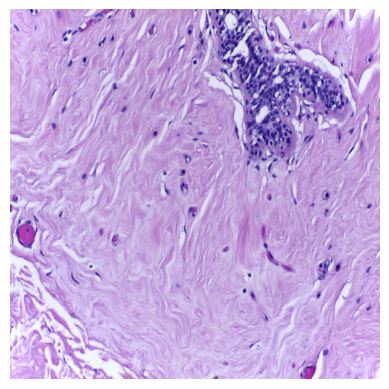

In [ ]:
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_random_image_from_dir(directory):
    # Get a list of image file names in the directory
    image_files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]

    # Select a random image file
    random_image_file = random.choice(image_files)

    # Load and display the image
    image_path = os.path.join(directory, random_image_file)
    image = mpimg.imread(image_path)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Usage example
directory_path = '/content/AugmentTrain/Benign'
show_random_image_from_dir(directory_path)

In [22]:
import os
import shutil

def get_directory_size(directory):
    total_size = 0
    for dirpath, _, filenames in os.walk(directory):
        for filename in filenames:
            filepath = os.path.join(dirpath, filename)
            total_size += os.path.getsize(filepath)
    return total_size

def print_directory_size(directory):
    size_bytes = get_directory_size(directory)
    size_mb = size_bytes / (1024 * 1024)
    print(f"Directory size: {size_mb:.2f} MB")

# Example usage
directory_path = '/content/BACHAugment'
print_directory_size(directory_path)


Directory size: 1808.86 MB


In [23]:
!mv /content/BACHAugment /content/drive/MyDrive

## Conclusion : Generated 4200 images for training and 100 for testing with no class imbalance